<h2>Подключаю все необходимые библеотеки </h2>

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes  import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from tqdm.auto import tqdm

In [2]:
#Очищаю память на GPU
torch.cuda.empty_cache()

<h2>Загрузка и вывод датасета</h2>

In [3]:
df = pd.read_csv('./train_spam.csv', delimiter=",")

In [4]:
df.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [5]:
#Проверяю размер датасета
df.shape

(16278, 2)

<h2>Проверка датасета на пропуски и повторы</h2>

In [6]:
#Пропусков нет
df.isna().sum()

text_type    0
text         0
dtype: int64

In [7]:
print("До удаления дубликатов:", df.shape[0])
df = df.drop_duplicates()
print("После удаления:", df.shape[0])
#Было 11 дубликатов, но, думаю, для выборки из 16к текстов это незначительно

До удаления дубликатов: 16278
После удаления: 16267


<h2>Проверим наличие дисбаланса классов</h2>

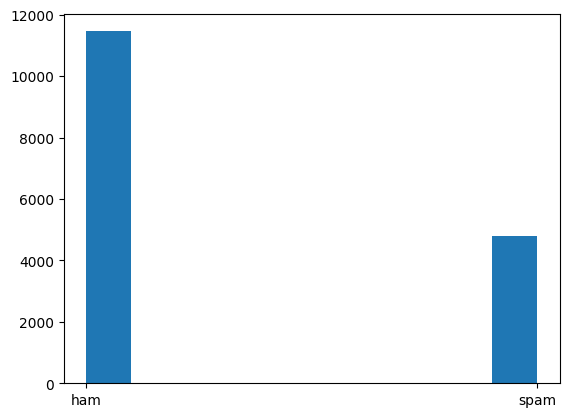

In [8]:
plt.hist(df["text_type"])
plt.plot();

<h2>Дисбаланс присутствует(оценочно спама 25%). Accuracy в данном случае лучше не использовать(по заданию ROC-AUC) </h2>

<h2>Посмотрим на распределение длины текстов</h2>

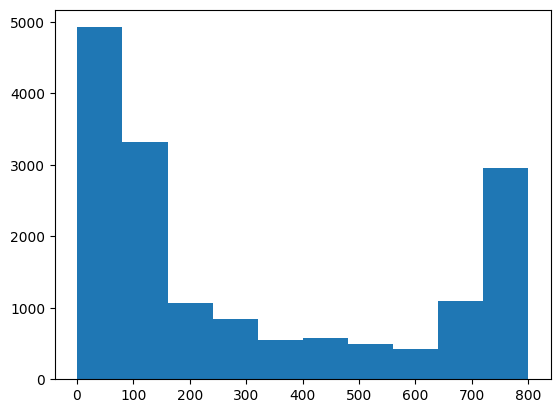

In [9]:
plt.hist(df["text"].map(lambda x: len(x)))
plt.plot();
#По распределению видно, что есть как очень длинные, так и очень короткие текста

In [10]:
#Здесь я создаю датафрейм, в котором спама и хама будет равное количество
#Чтобы избавиться от дисбаланса классов
spam = df[df["text_type"] == "spam"]
ham = df[df["text_type"] == "ham"][: spam.shape[0]]
spam_ham_df = pd.concat([spam.copy(), ham], ignore_index=True)
spam_ham_df = spam_ham_df.sample(frac=1, random_state=42).reset_index(drop=True)
spam_ham_df.head()

,text_type,text
0,spam,we have been rated as 1 one stop shop internet...
1,spam,books about thailand hello planning a trip to ...
2,ham,take some small dose tablet for fever
3,ham,latest revision vince i got the zipped version...
4,spam,its amazing when you know youre dealing with a...


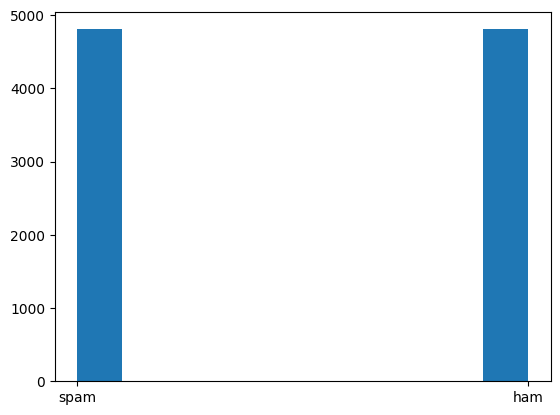

In [11]:
plt.hist(spam_ham_df["text_type"]);

In [12]:
def tokenize_df(tokenizer, df):
    """
    Функция, которая токенезирует текст.
    Если кол-во токенов слишком мало, то дополняет до 512.
    Если слишком много токенов, то обрезает до 512.
    """
    result_df = df.copy()
    result_df["text"] = result_df["text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    max_len = 512#Насколько помню - стандартно для токенайзера берта
    result_df["text"] = [i + [0]*(max_len-len(i)) for i in result_df["text"]]
    result_df["text"] = [i[:max_len] for i in result_df["text"]]
    return result_df

In [13]:
def prepare_features(model, padded, batch_size = 100):
    """
    Функция, которая преобразует токенезированный текст в эмбеддинг.
    Эмбеддинг дополнен позиционной составляющей.
    """
    result = []
    device = "cuda" if torch.cuda.is_available() else "cpu"
    with torch.no_grad():
        for cur_batch in tqdm(range(0, len(padded), batch_size)):
            batch_input_ids = padded[cur_batch:cur_batch+batch_size]
            attention_mask = torch.tensor(np.where(batch_input_ids.cpu().numpy() != 0, 1, 0)).to(device)
            last_hidden_states = model(batch_input_ids, attention_mask=attention_mask)
            result.extend(last_hidden_states[0][:,0,:].cpu().numpy())
            #print(f"Good for batch[{start}:{start+batch_size}]")
    return np.array(result)

In [14]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, 
                                                    ppb.DistilBertTokenizer, 
                                                    'distilbert-base-uncased')
# Загрузка предобученного DistilBert
model = model_class.from_pretrained(pretrained_weights)
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
#Далее два варианта df. Df - с дисбалансом. spam_ham_df - без дисбаланса, но выборка меньше.
train_df = spam_ham_df.copy()#Или просто df
train_df.loc[:,"text_type"] = train_df.loc[:,"text_type"].map({'spam': 1, 'ham': 0}).astype("int")
tokenized_df = tokenize_df(tokenizer, train_df)


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
#Токенизация текстов и добавление падинга(или обрезание до падинга)
prepared_data = torch.tensor(tokenized_df["text"]).to(device)
#Пропускаю через енкодер дистилберта, чтобы получить вкусные ебмединги
X = prepare_features(model, prepared_data, 5)

  0%|          | 0/1924 [00:00<?, ?it/s]

In [16]:
#Обрезаю количество лейблов до количества текстов
#Чтобы не было ситуации: 4000 текстов, а лейблов 4002(к примеру)
y = tokenized_df["text_type"][:X.shape[0]].astype("int")

In [17]:
#Инициализирую логистическую регрессию
#Пробовал разные солверы и регуляризацию, но прироста качества не дало
lr_clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=42)


In [18]:
#Обучаю
lr_clf.fit(X_train, y_train);

In [19]:
#Т.к лог. регрессия выдаёт мне вероятности принадлежности к 0 и к 1 классу
#То беру только те, которые к первому(т.к остальные алгоритмы возвращают эту вероятность)
#Что вполне логично. Т.к P(0) = 1 - P(1). 
predicts = lr_clf.predict_proba(X_test)[:, 1]
print(f"ROC-AUC score: {roc_auc_score(y_test, predicts)}")
log_reg_auc = roc_auc_score(y_test, predicts)

ROC-AUC score: 0.9889579771725118


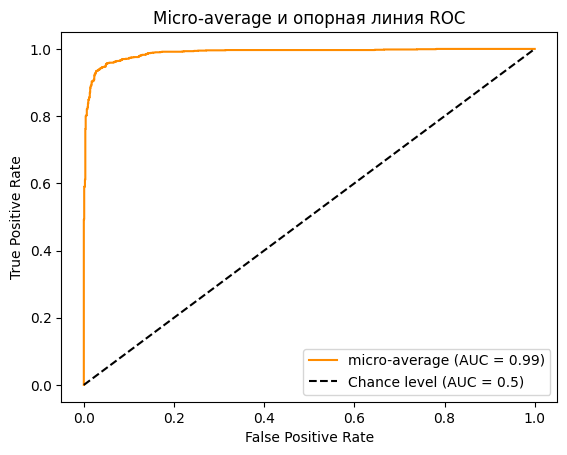

In [20]:
display = RocCurveDisplay.from_predictions(
    y_test.ravel(),
    predicts.ravel(),
    name="micro-average",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-average и опорная линия ROC",
)

In [21]:
#Наглядный пример, что логистическая регрессия отрабатывает действительно хорошо
print("Всего 1000 объектов, попаданий:", (lr_clf.predict(X_test[0:1000]) == 
                                         y_test.iloc[0:1000].ravel().astype("int")).sum())
#95.6% в целом хорошо состыкуется с нашим AUC(при увеличении выборки будет стремится к AUC)

Всего 1000 объектов, попаданий: 956


In [22]:
#Очищаю память GPU и создаю CatBoost классификатор
torch.cuda.empty_cache()
from catboost import CatBoostClassifier
cb_clf = CatBoostClassifier(iterations=1000,eval_metric="AUC",
                            random_seed=42, use_best_model = True,
                            task_type="GPU")


In [23]:
#Тренирую и вывожу график
cb_clf.fit(X_train, y_train, eval_set=(X_test, y_test), 
           verbose=200, plot=True, use_best_model=True
          )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.060198


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9040461	best: 0.9040461 (0)	total: 76ms	remaining: 1m 15s
200:	test: 0.9853300	best: 0.9853300 (200)	total: 12s	remaining: 47.7s
400:	test: 0.9876371	best: 0.9876371 (400)	total: 23.5s	remaining: 35s
600:	test: 0.9882457	best: 0.9882457 (600)	total: 34.7s	remaining: 23s
800:	test: 0.9887913	best: 0.9887913 (800)	total: 45.7s	remaining: 11.3s
999:	test: 0.9891945	best: 0.9892042 (995)	total: 55.6s	remaining: 0us
bestTest = 0.9892041683
bestIteration = 995
Shrink model to first 996 iterations.


In [24]:
#Делаю предсказание и беру только вероятность 1(спам)
#То же самое, что и с логистической регрессией
cb_predicts_proba = cb_clf.predict_proba(X_test)
cb_predicts_proba = cb_predicts_proba[:,1]

In [25]:
test_labels = y_test.astype("float32")

In [26]:
print(f"ROC-AUC score: {roc_auc_score(test_labels, cb_predicts_proba)}")
cat_boost_auc = roc_auc_score(test_labels, cb_predicts_proba)

ROC-AUC score: 0.9892041776626996


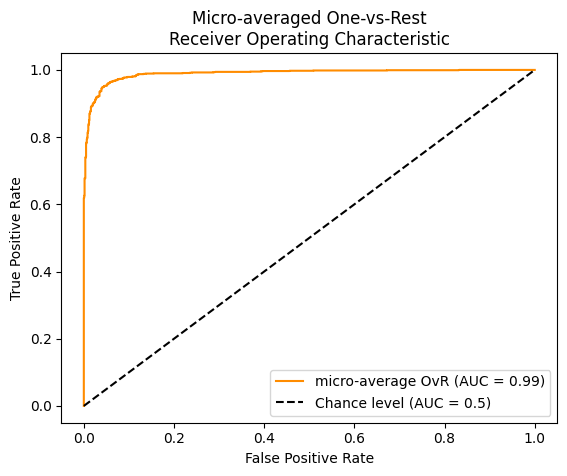

In [27]:
display = RocCurveDisplay.from_predictions(
    test_labels.ravel(),
    cb_predicts_proba.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [28]:
gs_clf = GaussianNB()
gs_clf.fit(X_train, y_train);

In [29]:
gs_predicts_proba = gs_clf.predict_proba(X_test)
gs_predicts_proba = gs_predicts_proba[:,1]
print(f"ROC-AUC score: {roc_auc_score(test_labels, gs_predicts_proba)}")
gaussian_nb_auc = roc_auc_score(test_labels, gs_predicts_proba)

ROC-AUC score: 0.931049685471958


In [30]:
print("RESULTS")
print(f"Логистическая регрессия AUC:{log_reg_auc}")
print(f"Catboost AUC:{cat_boost_auc}")
print(f"Байес AUC:{gaussian_nb_auc} ")

RESULTS
Логистическая регрессия AUC:0.9889579771725118
Catboost AUC:0.9892041776626996
Байес AUC:0.931049685471958 


<h2>Результат AUC</h2>

* Catboost = ~0.98-0.99 
* Логистическая регрессия = ~0.98-0.99
* Байес = 0.92-0.93

<h4>Catboost показывает совсем несущественное улучшение в AUC по сравнению с логистической регрессией.</br>
Я выбрал <a style="color:rgb(0,255,0);"> Логистическую регрессию </a> как финальный классификатор. </br>
Почему именно Логистическую регрессию:</br>
Требует существенно меньше времени и памяти на обучение и инференс, а разница в AUC крайне незначительна.
</h4>

<h3>Делаю предикт на test датасете</h3>

In [31]:
test_df = pd.read_csv("test_spam.csv")


In [32]:
test_tokenized_df = tokenize_df(tokenizer, test_df)
prepared_output_data = torch.tensor(test_tokenized_df["text"]).to(device)
X_output = prepare_features(model, prepared_output_data, 1)

  0%|          | 0/4070 [00:00<?, ?it/s]

In [33]:
output_predict = lr_clf.predict(X_output)

In [34]:
test_df.shape

(4070, 1)

In [35]:
result_df = test_df.copy()
result_df["text_type"] = output_predict
result_df["text_type"] = result_df["text_type"].map({1: 'spam', 0: 'ham'})
result_df.head()

,text,text_type
0,j jim whitehead ejw cse ucsc edu writes j you ...,ham
1,original message from bitbitch magnesium net p...,ham
2,java for managers vince durasoft who just taug...,ham
3,there is a youtuber name saiman says,ham
4,underpriced issue with high return on equity t...,ham


In [37]:
result_df.to_csv("submission.csv", sep=',', index=False)

<h2>Благодарю за уделенное время!</h2>